In [1]:
# Parámetros 
modelo = 'mod_titanic'

# Librerías 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Librería matriz de confusión
from sklearn.metrics import confusion_matrix
# Librería para curva de ROC
from sklearn.metrics import roc_curve, auc
# Para separar train y test 
from sklearn.model_selection import train_test_split
# Para modelar
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

# Para que no se muestren los warnings
import warnings
warnings.filterwarnings('ignore')

# Para instalar paquetes: 
# %pip install statsmodels --trusted-host pypi.org --trusted-host files.pythonhosted.org

In [2]:
# Importo dataset
url = 'Titanic.csv'
df = pd.read_csv(url, sep = ',')

## Feature Engineering

In [3]:
# Renombro el label 
df['label'] = df['Survived']

# Antes de entrenar, completo valores vacíos de la variable edad: 
edad_mediana = df['Age'].median()
df['Age_Completa'] = df['Age'].fillna(edad_mediana,
                                      inplace = False)
df['Age_Completa_log'] = np.log(df['Age_Completa'] )

# Genero binaria sexo 
df['Es_Fem'] = np.where(df['Sex'] == 'female',1,0)

df['Fare_log'] = np.log(df['Fare'] + 1)
df['SibSp_top'] = np.where(df['SibSp'] > 3,3,df['SibSp'])

df['Fare_Group'] = np.where(df['Fare'] <= 8,"Q",
                           np.where(df['Fare'] > 30, "C","S"))
df['Es_Q'] = np.where(df['Embarked'] == "Q", 1, 0)
df['Es_C'] = np.where(df['Embarked'] == "C", 1, 0)
df['Es_S'] = np.where(df['Embarked'] == "S", 1, 0)


# Variables con el nombre 
import re
df['Title'] = df['Name'].apply(lambda x : re.sub("(.*, )|(\\..*)", "", x)) 
df['Surname'] = df['Name'].apply(lambda x : x[:x.index(',')])
df['Fsize'] = df['SibSp'] + df['Parch'] + 1
df['Fsize'] = df['Fsize'].astype('str')
df['Family'] = df[['Surname', 'Fsize']].agg('_'.join, axis=1)

df['Mother'] = np.where((df['Sex'] == 'female') & 
                        (df['Parch'] > 0) & 
                        (df['Title'] != 'Miss'),1,0)
df['Fsize'] = df['Fsize'].astype('int')
df['FsizeD'] = np.where(df.Fsize ==1, 'singleton',
                        np.where(((df.Fsize <5) & (df.Fsize >1)),'small','large'))

# Encoding
df['Es_Q'] = np.where(df['Embarked'] == "Q", 1, 0)
df['Es_C'] = np.where(df['Embarked'] == "C", 1, 0)
df['Es_S'] = np.where(df['Embarked'] == "S", 1, 0)
df['Es_Master'] = np.where(df['Title'] == "Master", 1, 0)
df['Es_Miss'] = np.where(df['Title'] == "Miss", 1, 0)
df['Es_Mr'] = np.where(df['Title'] == "Mr", 1, 0)
df['Es_Mrs'] = np.where(df['Title'] == "Mrs", 1, 0)
df['Es_singleton'] = np.where(df['FsizeD'] == "singleton", 1, 0)
df['Es_small'] = np.where(df['FsizeD'] == "small", 1, 0)
df['Es_Pclass_1'] = np.where(df['Pclass'] == 1, 1, 0)
df['Es_Pclass_3'] = np.where(df['Pclass'] == 3, 1, 0)
df['Tiene_Parch'] = np.where(df['Parch'] > 0, 1, 0)

df['Fare_log'] = np.log(np.where(df['Fare'] > df['Fare'].quantile(0.99),
                                 df['Fare'].quantile(0.99),
                                 df['Fare'])+ 1)

## TRAIN Y TEST 

In [4]:
#### Train y Test
X_train, X_test = train_test_split(df, test_size=0.3, random_state=14, stratify=df['label']);
X_train = X_train.reset_index()
X_test = X_test.reset_index()

# Check tasas similares 
print('Tasa Promedio del Label - TRAIN:')
print(round(X_train['label'].mean(),4)*100,'%')
print('-------------------------')
print('Tasa Promedio del Label - TEST:')
print(round(X_test['label'].mean(),4)*100,'%')

Tasa Promedio del Label - TRAIN:
38.36 %
-------------------------
Tasa Promedio del Label - TEST:
38.43 %


# Algoritmo a probar: XGBoost 

In [5]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'label', 'Age_Completa',
       'Age_Completa_log', 'Es_Fem', 'Fare_log', 'SibSp_top', 'Fare_Group',
       'Es_Q', 'Es_C', 'Es_S', 'Title', 'Surname', 'Fsize', 'Family', 'Mother',
       'FsizeD', 'Es_Master', 'Es_Miss', 'Es_Mr', 'Es_Mrs', 'Es_singleton',
       'Es_small', 'Es_Pclass_1', 'Es_Pclass_3', 'Tiene_Parch'],
      dtype='object')

In [95]:
#### Features y target

features = ['Age_Completa_log','Es_Fem','Fare_log',
           'SibSp_top', 'Es_C', 'Es_S', 
            'Es_Miss',
            'Es_Mrs','Es_singleton','Es_small',
           'Tiene_Parch',
           'Pclass']

target_column = 'label'

#### Hiperparametros

param_test={'gamma': [0.1],
            'max_depth':[5,6],
            'n_estimators': [50, 80],
            'learning_rate':[0.02],
            'objective':['binary:logistic'],
            'seed':[555551234], 
            'base_score':[0.5], 
            'booster' : ['gbtree'],
            'gpu_id' : [-1],
            'importance_type' : ['gain'],
            'reg_alpha' : [0.1],
            'reg_lambda' : [0.1], 
            'scale_pos_weight' : [1],
            'tree_method' : ['auto'],
            'min_child_weight': [10], 
            'colsample_bytree' : [0.6,0.7],
            'subsample' : [0.6,0.7]
                                 }


cross_val = StratifiedKFold(n_splits=3)

xgb_model = xgb.XGBClassifier(seed=1234) 

gs = RandomizedSearchCV( estimator=xgb_model,
                         param_distributions=param_test,
                         n_iter=100,
                         scoring='roc_auc',
                         cv=cross_val,
                         refit=True,
                        random_state=314
                                        )

gs.fit(X_train[features],X_train[target_column])

############################
# El mejor modelo
############################

opt_parameters = gs.best_estimator_.get_params()

print('Hiperparámetros Ganadores')
print(opt_parameters)

xgb_model = xgb.XGBClassifier(objective=gs.best_estimator_.get_params()['objective'],
                              seed = gs.best_estimator_.get_params()['seed'],
                              base_score = gs.best_estimator_.get_params()['base_score'],
                              booster = gs.best_estimator_.get_params()['booster'],
                              gpu_id = gs.best_estimator_.get_params()['gpu_id'],
                              importance_type = gs.best_estimator_.get_params()['importance_type'],
                              reg_alpha = gs.best_estimator_.get_params()['reg_alpha'],
                              reg_lambda = gs.best_estimator_.get_params()['reg_lambda'],
                              scale_pos_weight = gs.best_estimator_.get_params()['scale_pos_weight'],
                              tree_method = gs.best_estimator_.get_params()['tree_method'],
                              min_child_weight=gs.best_estimator_.get_params()['min_child_weight'],
                              colsample_bytree = gs.best_estimator_.get_params()['colsample_bytree'],
                              subsample = gs.best_estimator_.get_params()['subsample'],
                              gamma = gs.best_estimator_.get_params()['gamma'],
                              max_depth = gs.best_estimator_.get_params()['max_depth'],
                              n_estimators = gs.best_estimator_.get_params()['n_estimators'],
                              learning_rate = gs.best_estimator_.get_params()['learning_rate'],

                                        )

# Entreno el modelo final
clf_final_train = xgb_model.fit(X_train[features], X_train[target_column] )

# Predicciones
y_pred_train = clf_final_train.predict(X_train[features])
y_pred_test = clf_final_train.predict(X_test[features])
y_pred_prob_train = clf_final_train.predict_proba(X_train[features])[:,1]
y_pred_prob_test = clf_final_train.predict_proba(X_test[features])[:,1]

Hiperparámetros Ganadores
{'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': 0.1, 'grow_policy': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.02, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 10, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 80, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'sampling_method': None, 'scale_pos_weight': 1, 'subsample': 0.7, 'tree_method': 'auto', 'validate_parameters': None, 'verbosity': None, 'seed': 555551234, 'gpu_id': -1}


## Métricas de Validación: AUC y Gini

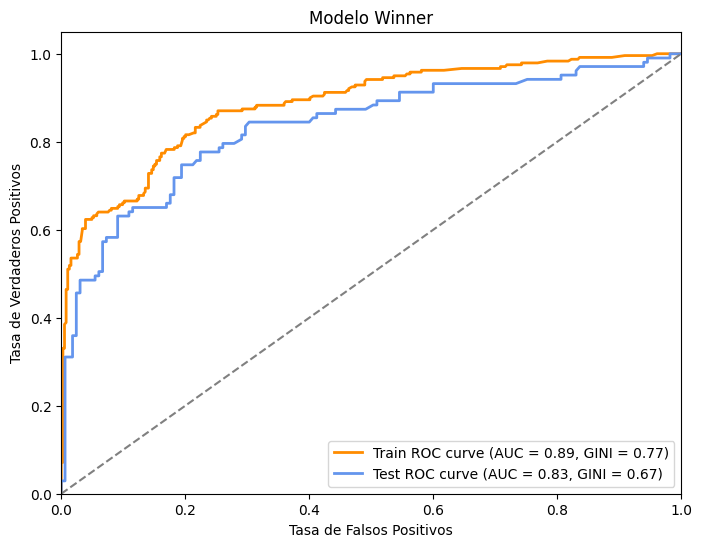

In [96]:
# Calcula las curvas ROC y el área bajo la curva (AUC) para entrenamiento y prueba
y_train = X_train[target_column] 
y_train_proba = y_pred_prob_train
X_train['Prediction'] = y_pred_prob_train
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
roc_auc_train = auc(fpr_train, tpr_train)
gini_train = 2 * roc_auc_train - 1

y_test = X_test[target_column] 
y_test_proba = y_pred_prob_test
X_test['Prediction'] = y_pred_prob_test
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
roc_auc_test = auc(fpr_test, tpr_test)
gini_test = 2 * roc_auc_test - 1

# Grafica las curvas ROC en el mismo gráfico
roc_1 = plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f}, GINI = {gini_train:.2f})')
plt.plot(fpr_test, tpr_test, color='cornflowerblue', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f}, GINI = {gini_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Modelo Winner')
plt.legend(loc='lower right')

In [98]:
print('GINI Train:',round(gini_train,2))
print('GINI Test:',round(gini_test,2))

GINI Train: 0.77
GINI Test: 0.67


## Tablas de Performance

In [75]:
# Agrego predicción en mi dataframes
X_train['Predict_Prob'] = y_pred_prob_train
X_test['Predict_Prob'] = y_pred_prob_test

# Quintiles
quintiles = np.percentile(X_train['Predict_Prob'], [10, 20, 30, 40, 50, 60, 70, 80, 90])
X_train['Predict_Prob_Bin'] = np.digitize(X_train['Predict_Prob'], quintiles)

quintiles = np.percentile(X_test['Predict_Prob'], [10, 20, 30, 40, 50, 60, 70, 80, 90])
X_test['Predict_Prob_Bin'] = np.digitize(X_test['Predict_Prob'], quintiles)


# Genero agrupaciones
performance_train = X_train.groupby('Predict_Prob_Bin').agg(     
    Label = ('label', 'sum'),
    Total = ('label', 'count'),
    Tasa = ('label', 'mean'),
    Min_Pred = ('Predict_Prob', 'min'),
    Max_Pred = ('Predict_Prob', 'max')
).reset_index()

performance_test = X_test.groupby('Predict_Prob_Bin').agg(     
    Label = ('label', 'sum'),
    Total = ('label', 'count'),
    Tasa = ('label', 'mean'),
    Min_Pred = ('Predict_Prob', 'min'),
    Max_Pred = ('Predict_Prob', 'max')
).reset_index()

print('Performance TRAIN')
print('')
print(performance_train.round(3).sort_values(by = 'Predict_Prob_Bin',ascending = False))
print('')
print('')
print('--------------------------------------')
print('')
print('Performance TEST')
print('')
print(performance_test.round(3).sort_values(by = 'Predict_Prob_Bin',ascending = False))

Performance TRAIN

   Predict_Prob_Bin  Label  Total   Tasa  Min_Pred  Max_Pred
9                 9     62     63  0.984     0.891     0.942
8                 8     58     62  0.935     0.686     0.891
7                 7     44     63  0.698     0.516     0.667
6                 6     24     61  0.393     0.389     0.513
5                 5     21     63  0.333     0.294     0.384
4                 4     11     63  0.175     0.190     0.293
3                 3      8     62  0.129     0.147     0.189
2                 2      6     62  0.097     0.124     0.147
1                 1      3     67  0.045     0.096     0.122
0                 0      2     57  0.035     0.073     0.096


--------------------------------------

Performance TEST

   Predict_Prob_Bin  Label  Total   Tasa  Min_Pred  Max_Pred
9                 9     26     27  0.963     0.900     0.937
8                 8     23     27  0.852     0.827     0.897
7                 7     16     27  0.593     0.535     0.721
6     

## Importancia de Features

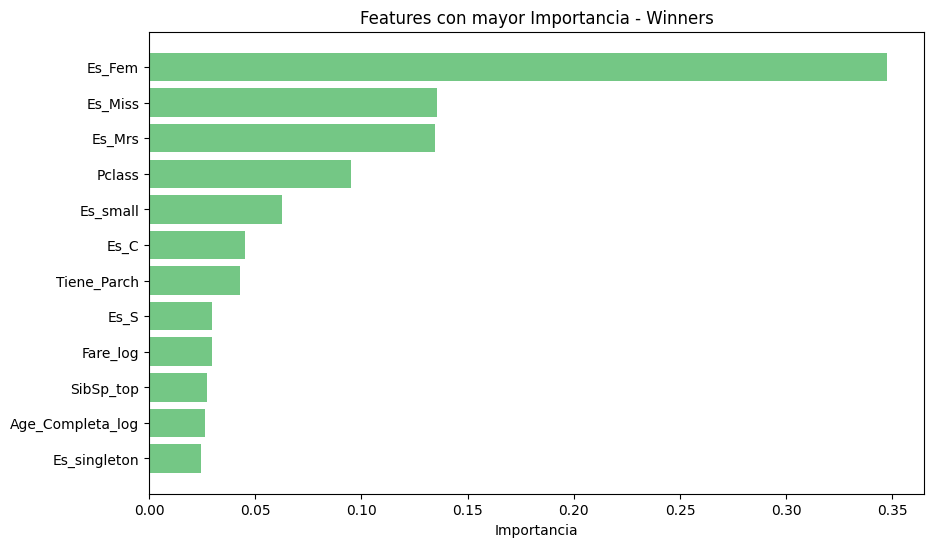

In [76]:
# Obtener la importancia de las características
feature_importance = clf_final_train.feature_importances_

# Crear un DataFrame para visualizar la importancia de las características
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values('Importance', ascending=False)
importance_completo = importance_df

# Grafico la importancia de cada variable
importance_df = importance_df.sort_values(by = 'Importance', ascending = False)
plt.figure(figsize=(10, 6))  # Tamaño de la figura
plt.barh(importance_df['Feature'], 
         importance_df['Importance'],
         color = '#74C785')
plt.xlabel('Importancia')
plt.title('Features con mayor Importancia - Winners')
plt.gca().invert_yaxis()  
plt.show() 

## Correlaciones

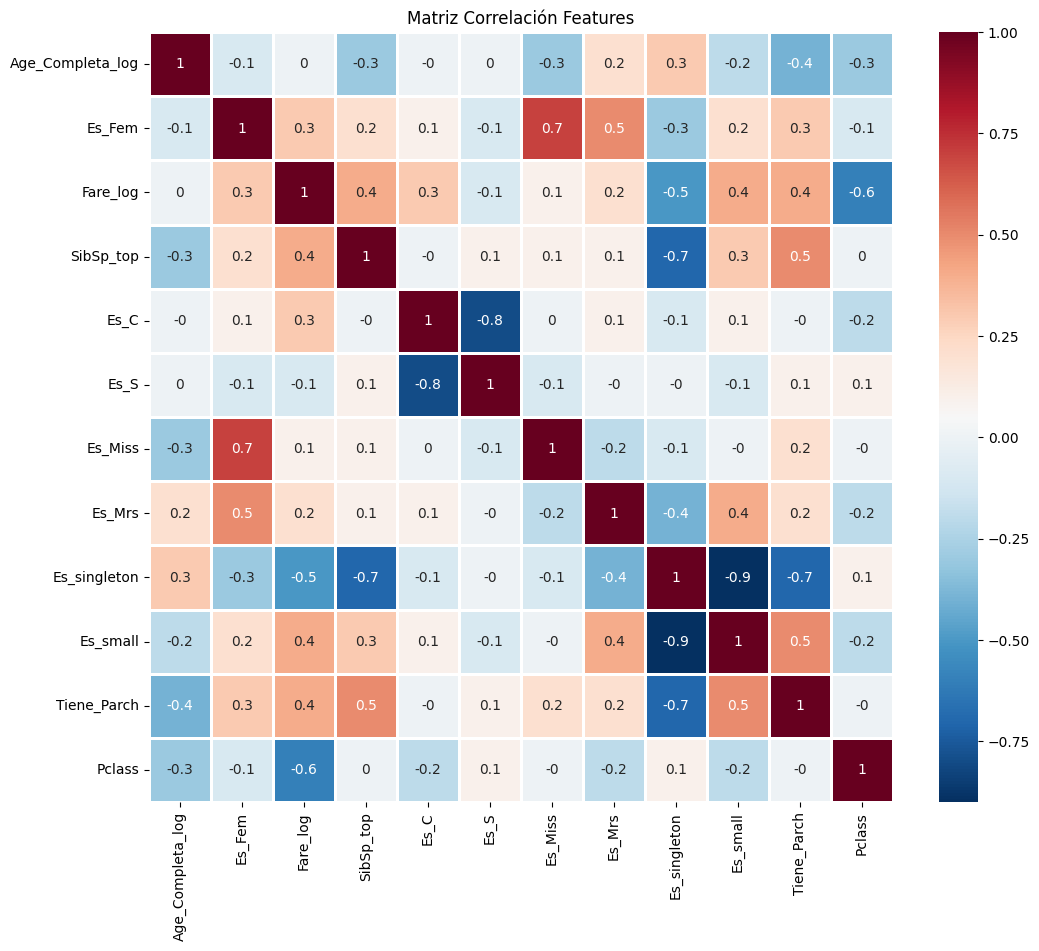

In [77]:
# Matriz de correlacion
matriz_corr = X_train[features].corr()
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(round(matriz_corr,1), annot=True,
            cmap = 'RdBu_r',            
            lw = 1)
plt.title('Matriz Correlación Features')
plt.show()

# **Shap Values**

In [11]:
import shap

## Partial Dependence Plot (PDP)

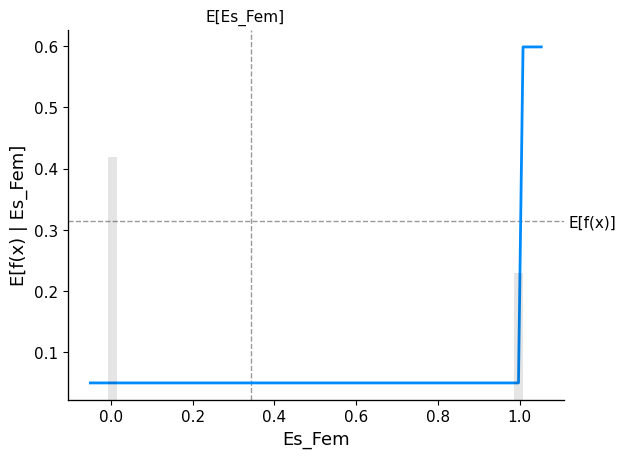

In [78]:
# Subset de predictores
X = X_train[features]

# Plot de dependencia parcial
shap.partial_dependence_plot(
    "Es_Fem",
    xgb_model.predict,  # o model.predict_proba si querés probabilidades
    X,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

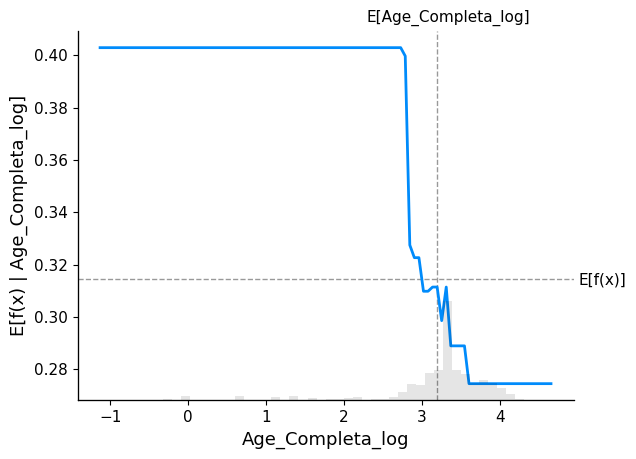

In [79]:
# Plot de dependencia parcial
shap.partial_dependence_plot(
    "Age_Completa_log",
    xgb_model.predict,  # o model.predict_proba si querés probabilidades
    X,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

## Waterfall Plot SHAP

In [80]:
# Primero, distribución general 
print('Tasa Promedio:',df['label'].mean().round(2))
print('Prediccion Promedio Train:',y_train_proba.mean().round(2))
print('Prediccion Promedio Test:',y_test_proba.mean().round(2))

Tasa Promedio: 0.38
Prediccion Promedio Train: 0.39
Prediccion Promedio Test: 0.4


In [82]:
# Luego, distribución por variable 
variable_analizar = 'Es_Fem' 
X_train.groupby(variable_analizar).agg(
    Cantidad = ('label', 'count'),
    Tasa = ('label', 'mean')
).reset_index()

,Es_Fem,Cantidad,Tasa
0,0,409,0.185819
1,1,214,0.761682


In [83]:
# Luego, distribución por variable Edad 
X_train['Edad_cuartiles'] = pd.qcut(X_train['Age_Completa_log'], q=4, labels=['Q1','Q2','Q3','Q4'])
X_train.groupby('Edad_cuartiles').agg(
    Cantidad = ('Survived', 'count'),
    Tasa = ('Survived', 'mean'),
    Edad_Min = ('Age_Completa', 'min')
).reset_index()

,Edad_cuartiles,Cantidad,Tasa,Edad_Min
0,Q1,167,0.443114,0.42
1,Q2,214,0.322430,23.00
2,Q3,92,0.434783,28.50
3,Q4,150,0.373333,36.00


Registro Nro: 50

Valores:
Age_Completa_log    3.701302
Es_Fem                     0
Fare_log            2.169054
SibSp_top                  0
Es_C                       0
Es_S                       0
Es_Miss                    0
Es_Mrs                     0
Es_singleton               1
Es_small                   0
Tiene_Parch                0
Pclass                     3
label                      0
Prediction          0.090299
Age                     40.5
Name: 50, dtype: object


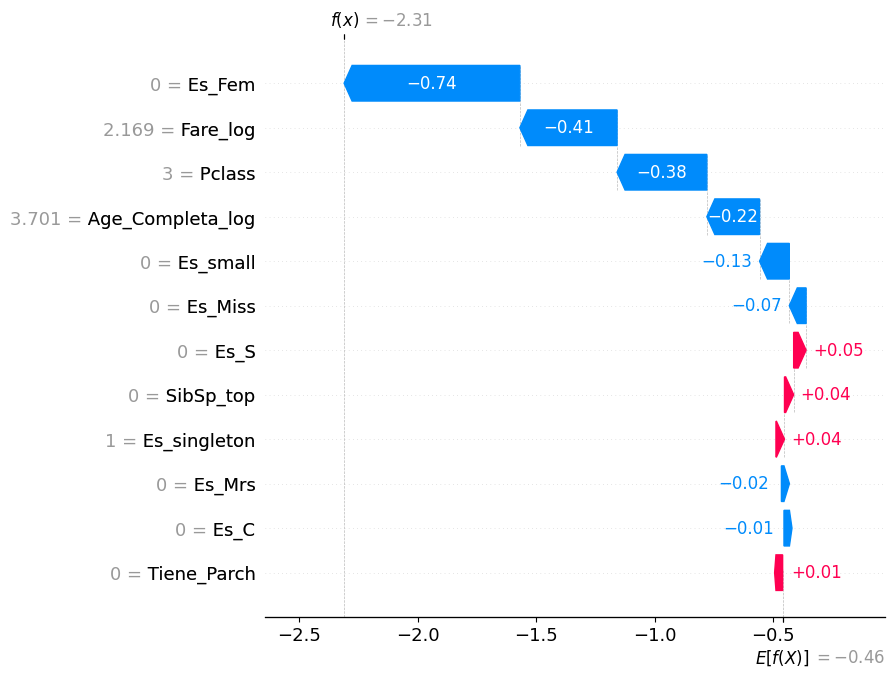

In [86]:
# compute the SHAP values for the linear model
sample_ind = 50
explainer = shap.Explainer(xgb_model, X)
shap_values = explainer(X)

# Valores del registro
cols = features + ['label','Prediction','Age']

print('Registro Nro:', sample_ind)
print('')
print('Valores:')
print(X_train.iloc[sample_ind,][cols])

# Plot
shap.plots.waterfall(shap_values[sample_ind], max_display=14)


## SHAP Beeswarm Plot

PermutationExplainer explainer: 624it [01:09,  7.58it/s]                         


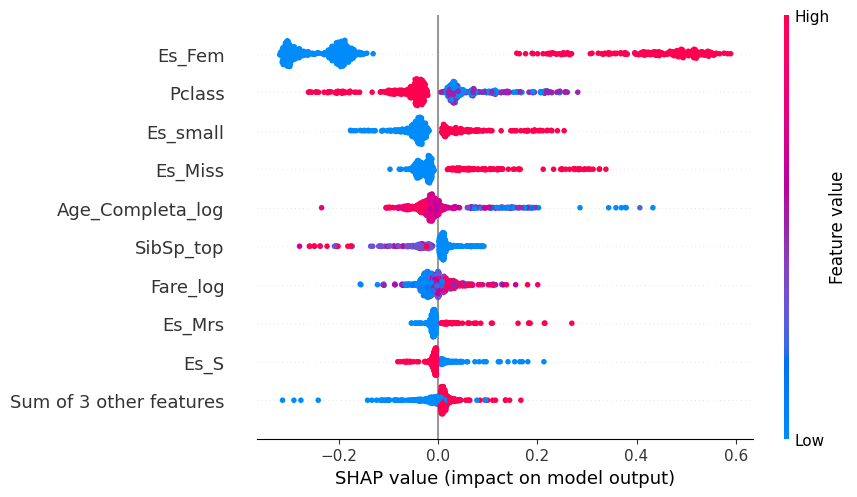

In [87]:
# explain the GAM model with SHAP
explainer_ebm = shap.Explainer(xgb_model.predict, X)
shap_values_ebm = explainer_ebm(X)
shap.plots.beeswarm(shap_values_ebm)

### Interpretación de algunas distribuciones de SHAP Values: 

* *Es_Fem:* Los valores celestes se concentran en en SHAP values negativos, y los valores rojos en SHAP values positivos. Esto indica que ser mujer, incrementa la probabilidad de sobrevivir. 

* *PClass:* Esta variable toma valores de 1 a 3, donde 1 es primera clase, 2 una clase media y 3 tercera clase. En el gráfico se observa que, a mayor clase (peor tipo de ticket), menos probabilidad de sobrevivir.



## SHAP Dependence Plot

**Aclaración:** automáticamente, la función de SHAP al hacer un shap.plots.scatter() con color=shap_values, elige una variable del dataset que:

* Tiene alta correlación con la variable que estás graficando,

* Tiene interacción relevante con ella,

* Afecta el modelo en conjunto con esa variable.

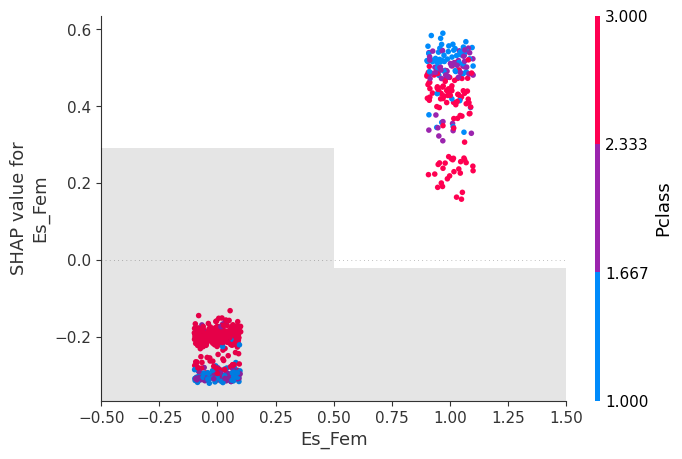

In [88]:
shap.plots.scatter(shap_values_ebm[:, "Es_Fem"], color=shap_values)

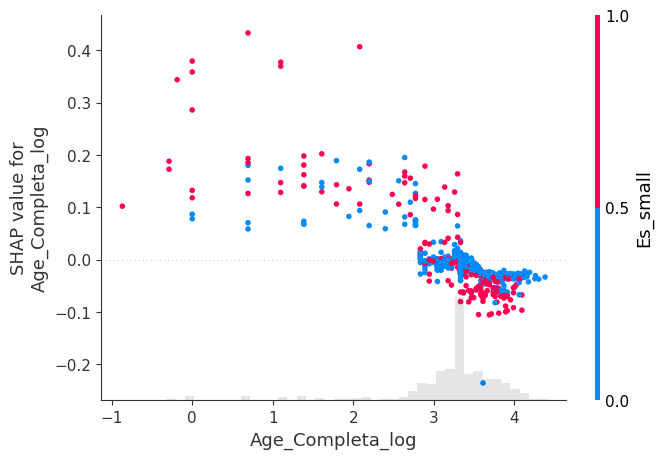

In [89]:
shap.plots.scatter(shap_values_ebm[:, "Age_Completa_log"], color=shap_values)

## Paso Final: Exportación del modelo para ponerlo en Prod. 

In [90]:
# Exporto el modelo 
import pickle

local_model_path = modelo+'.pkl'
with open(local_model_path, 'wb') as f:
    pickle.dump(clf_final_train, f)